In [3]:
import os, sys
import IPython
import IPython.display
import torch
import pytorch_lightning as pl
from IPython.core.display import HTML

from draft.models.MobileNet.classifier import AgeGenderClassifier
from draft.models.MobileNet.data_loader import create_dataloaders
import draft.models.MobileNet.data_defs as data_defs
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms.v2 as transforms
import random
import importlib
import matplotlib.pyplot as plt
from PIL import Image
import Notebooks.utils.utils as utils

In [4]:
MODEL_NAME = "wandering-oath-85_51_0.8182.pth"

In [6]:
utils.fix_cwd()

In [5]:
os.getcwd()

'/mnt/v/projects/DL_s3/Notebooks'

# Preprocessing and Hyper-parameter tuning

In this notebook we'll discuss our full model pipeline:
    - sampling
    - preprocessing
    - transformation/augmentation
    - balancing/oversampling
etc.

And additionally the hyperparmeter tuning approach we took to select optimal transformations and parameter for our model.

### Data Sampling

We've split the dataset into test and training samples roughly trying to maintain an around 15% test sample size. The sample ratios used in our model training:

- Test: 20% of full dataset:
- Training: 80%

During hyper-parameter tuning we've further split the training dataset:
- Validation: 20% of remaining samples (i.e. 17% of full dataset)
- Remaining images used for training: 64%

#### Full Pipeline and Model:



##### ***Preprocessing and balancing:***

  -  Validation/test samples are normalized and resized
  -  Additionally, a variable number of transformations are applied to the training sample
  -  (optional: augmentation based oversampling can be used based on selected binned continuous variable, which generates additional transformed duplicate images)

##### ***Model:***

- Base Model (MobileNetV3 Small):

    - Initial Conv2d layer
    - Series of Inverted Residual Blocks (specific to MobileNetV3 architecture)
    - Final Conv2d layer
        - (The classifier part of the original MobileNetV3 was removed)


- Global Pooling Layer, `AdaptiveAvgPool2d(1)` (reduces the model output shape `(batch_size, 576, height, width)` - > `(batch_size, 576, 1, 1)`)

- Two Custom Heads:
    - Gender Classifier:
        - Dropout layer
        - Linear layer: (576 -> 2)
        - Input features: 576 (MobileNetV3 Small's last_channel)
        - Output features: 2 (for binary gender classification)

    - Age Regressor
        - Dropout layer
        - Linear layer: (576 -> 1)
        - Input features: 576
        - Output features: 1 (for age regression)





### Visualizing Torchvision Transforms

As part of your hyperparameter tuning process we've selected the optimal transformations to use with our model.

Each enabled transformation is sequaintlly applied to each image:

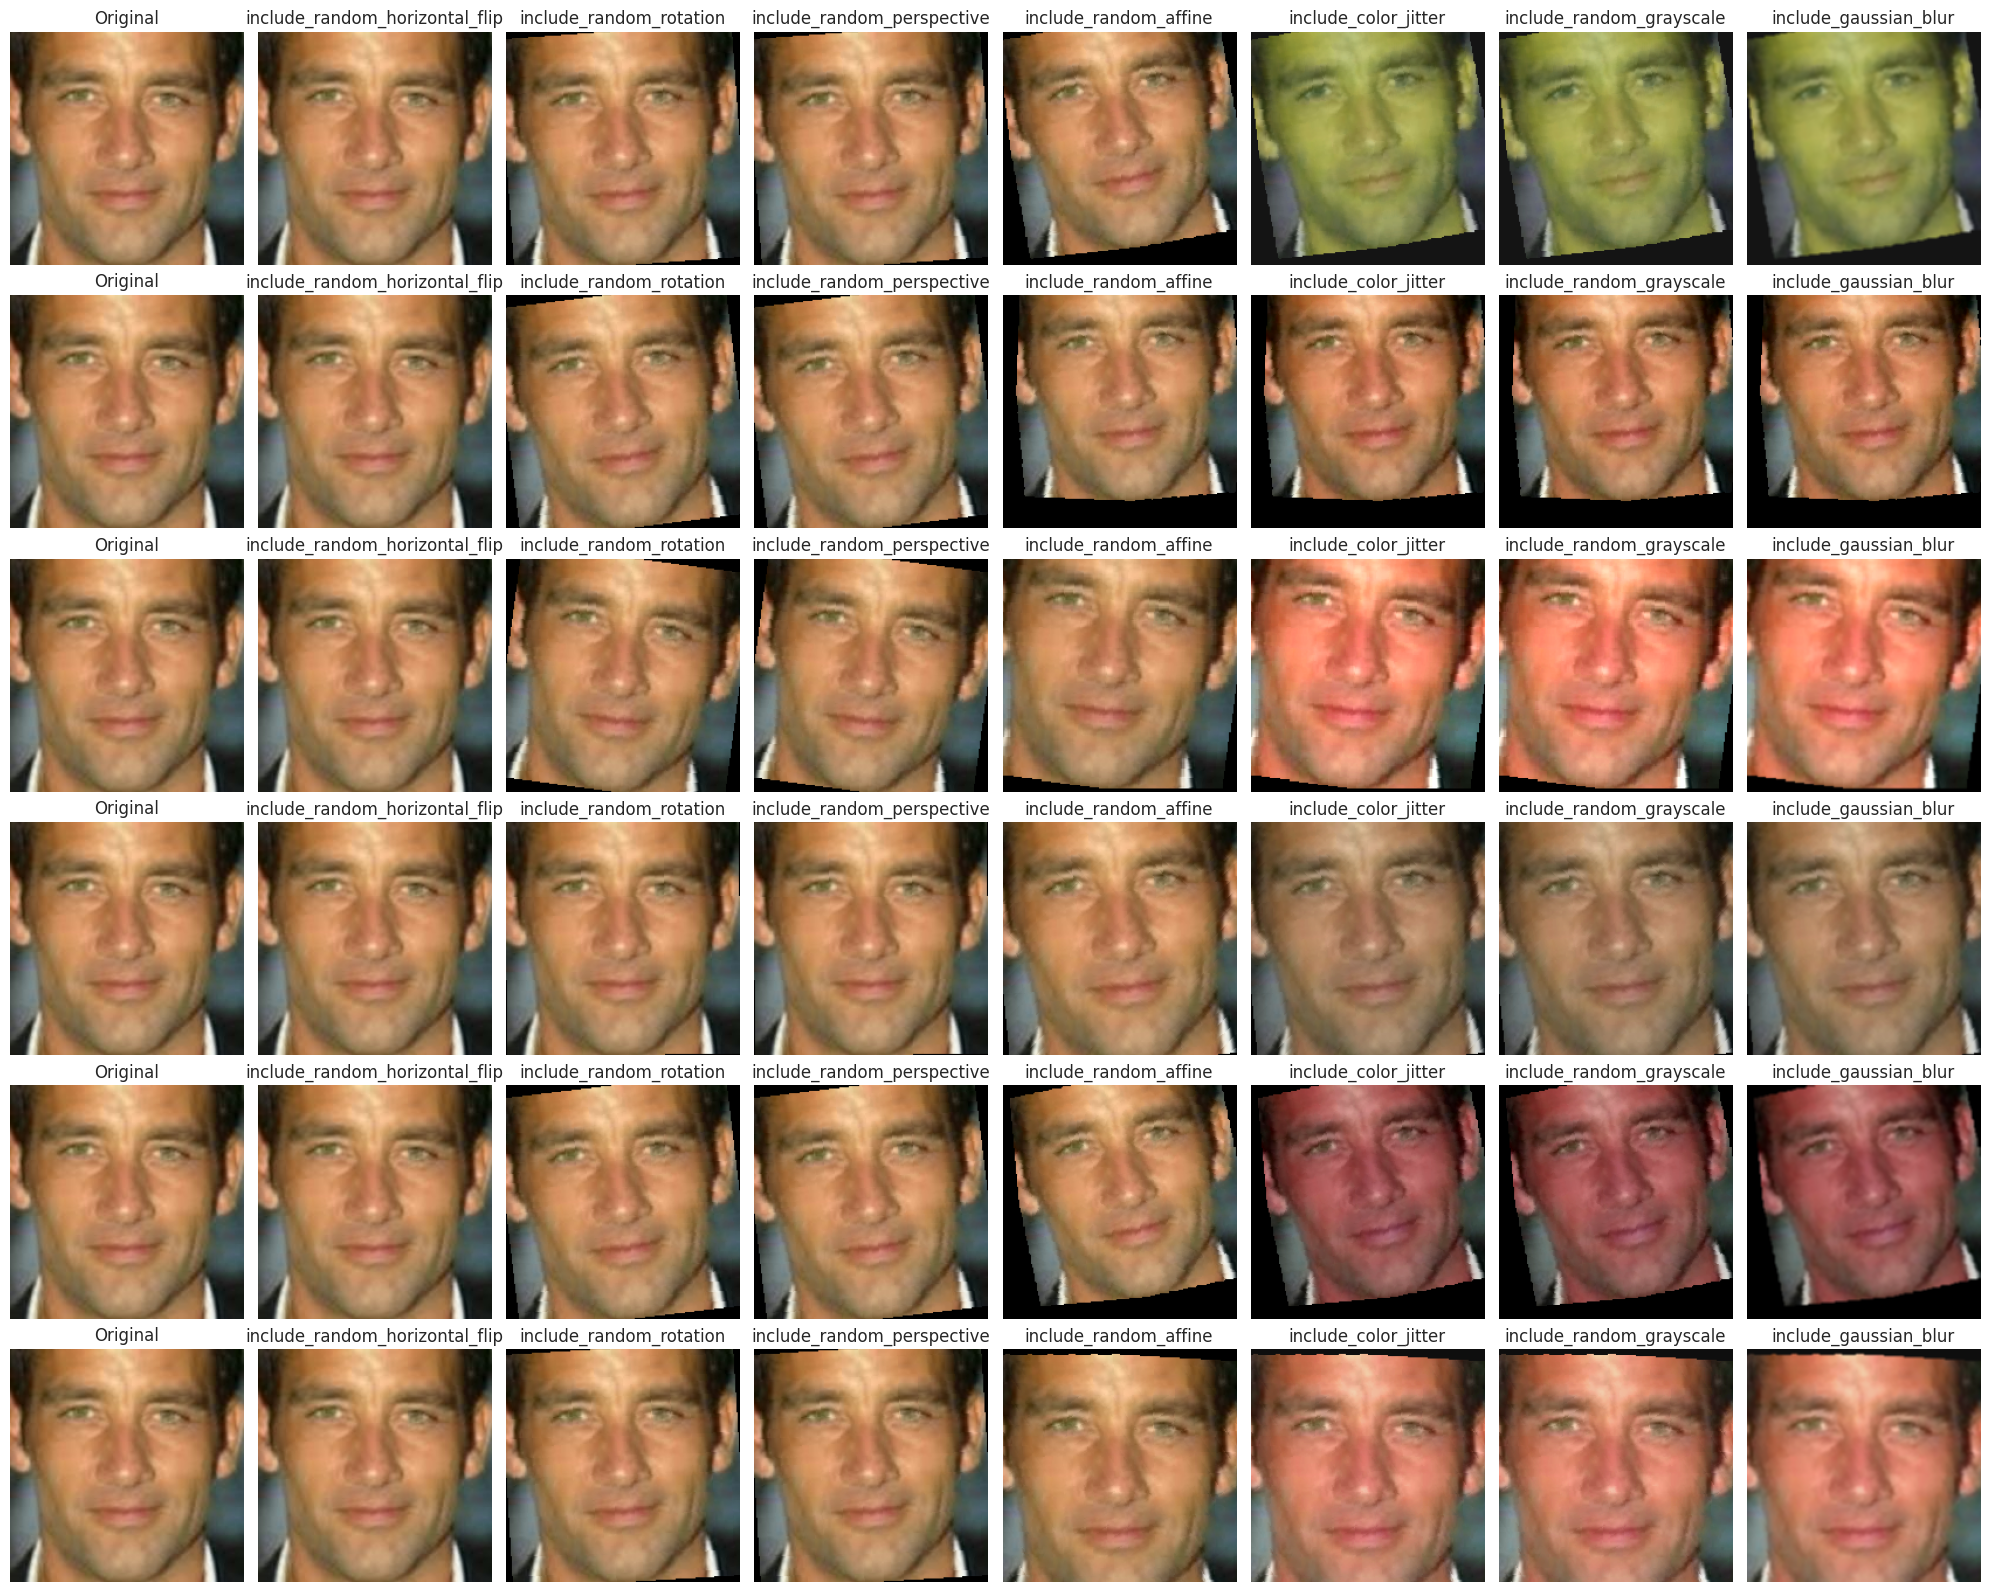

In [7]:
importlib.reload(data_defs)


def visualize_transforms(image_path, transforms_configs, num_rows=6):
    img = Image.open(image_path).convert("RGB")

    all_results = []
    for _ in range(num_rows):
        results = [("Original", img)]
        current_img = img
        for config_key, transform in transforms_configs:
            current_img = transform(current_img)
            if isinstance(current_img, torch.Tensor):
                current_img = transforms.ToPILImage()(current_img)
            results.append((config_key, current_img))
        all_results.append(results)

    fig, axs = plt.subplots(
        num_rows, len(transforms_configs) + 1, figsize=(20, 3.5 * num_rows)
    )
    for row, results in enumerate(all_results):
        for col, (name, img) in enumerate(results):
            axs[row, col].imshow(img)
            axs[row, col].set_title(name)
            axs[row, col].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.65)  # Adjust hspace and top as needed


visualize_transforms(
    "dataset/full/40_0_0_20170117151450653.jpg.chip.jpg",
    transforms_configs=data_defs.get_transforms_configs(),
)

#### Selecting Best Transformers:

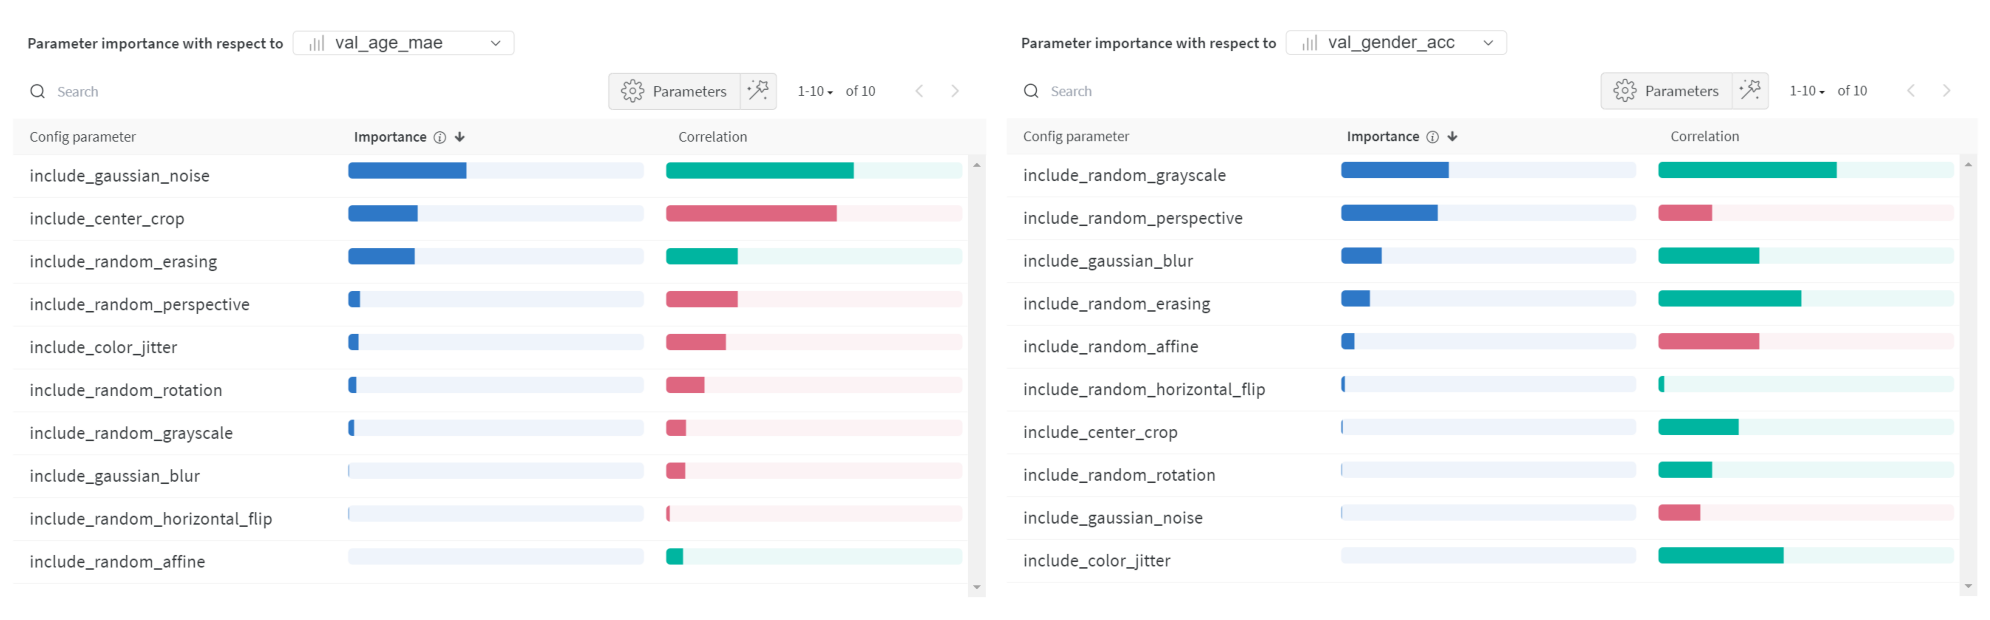

In [10]:
img1 = Image.open("Notebooks/imgs/tune_transforms_age_mae.png")
img2 = Image.open("Notebooks/imgs/tune_transforms_gender.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(img1)
ax2.imshow(img2)

ax1.axis("off")
ax2.axis("off")

plt.tight_layout()
plt.show()

(For `val_age_mae` red is good i.e. we want to minimize it and bad for `val_gender_acc`)

We can see that there is significant variance between the effect of each transform depending on if we're classifying gender or estimating age. 

We have chosen to exclude the transforms that have signficant negative:

```
include_center_crop: True
include_color_jitter: True
include_gaussian_blur: True
include_gaussian_noise: False
include_random_affine: False
include_random_erasing: False
include_random_grayscale: true
include_random_horizontal_flip: False
include_random_perspective: True
include_random_rotation: True
```

### Model Hyper-parameter Tuning:


In [16]:
%%html
<iframe src="https://wandb.ai/qqwy/ag_classifier_main/reports/Untitled-Report--Vmlldzo4ODIwMzE4" style="border:none;height:1024px;width:100%">

You can view detailed charts for final runs used to select the optimal configurations here: [Summary in Wandb](https://api.wandb.ai/links/qqwy/sa16va7v)

(this reports shows final runs with most of the parameters stabilized to very narrow ranges, more extensive tuning was used to select the appropriate base_lr, schedulers, batch_size etc.) 

This [report](https://api.wandb.ai/links/qqwy/ukvgwfil) has pretty much all of the parameter that have been tried (not that it contains runs of multiple different tuning sessions/sweeps and might have used different samples etc. so it's included to give a broad approximate picture.



## Additional Transformation used with Augmentation Based Oversampling:

We've chosen to include 2 final versions of our model:

- `V1/baseline` no oversampling, all images in the dataset are only used once with randomly selected transformations to applied to a random proportion of them each epoch.
- `V2/improved` same as above but additional augmented samples are used for all age bins

Training sample summary for both moodel:

Without oversampling:

| Age Range | Count |
|-----------|-------|
| 0-9       | 2452  |
| 10-19     | 1268  |
| 20-29     | 5816  |
| 30-39     | 3586  |
| 40-49     | 1837  |
| 50-59     | 1845  |
| 60-69     | 1068  |
| 70-79     | 543   |
| 80-89     | 541   |

With augmented samples and oversampling:

| Age Range | Count |
|-----------|-------|
| 0-9       | 4042  |
| 10-19     | 3213  |
| 20-29     | 6397  |
| 30-39     | 4836  |
| 40-49     | 3611  |
| 50-59     | 3617  |
| 60-69     | 3073  |
| 70-79     | 2705  |
| 80-89     | 2704  |


***Examples of additional augmented duplicate samples that could be included:***


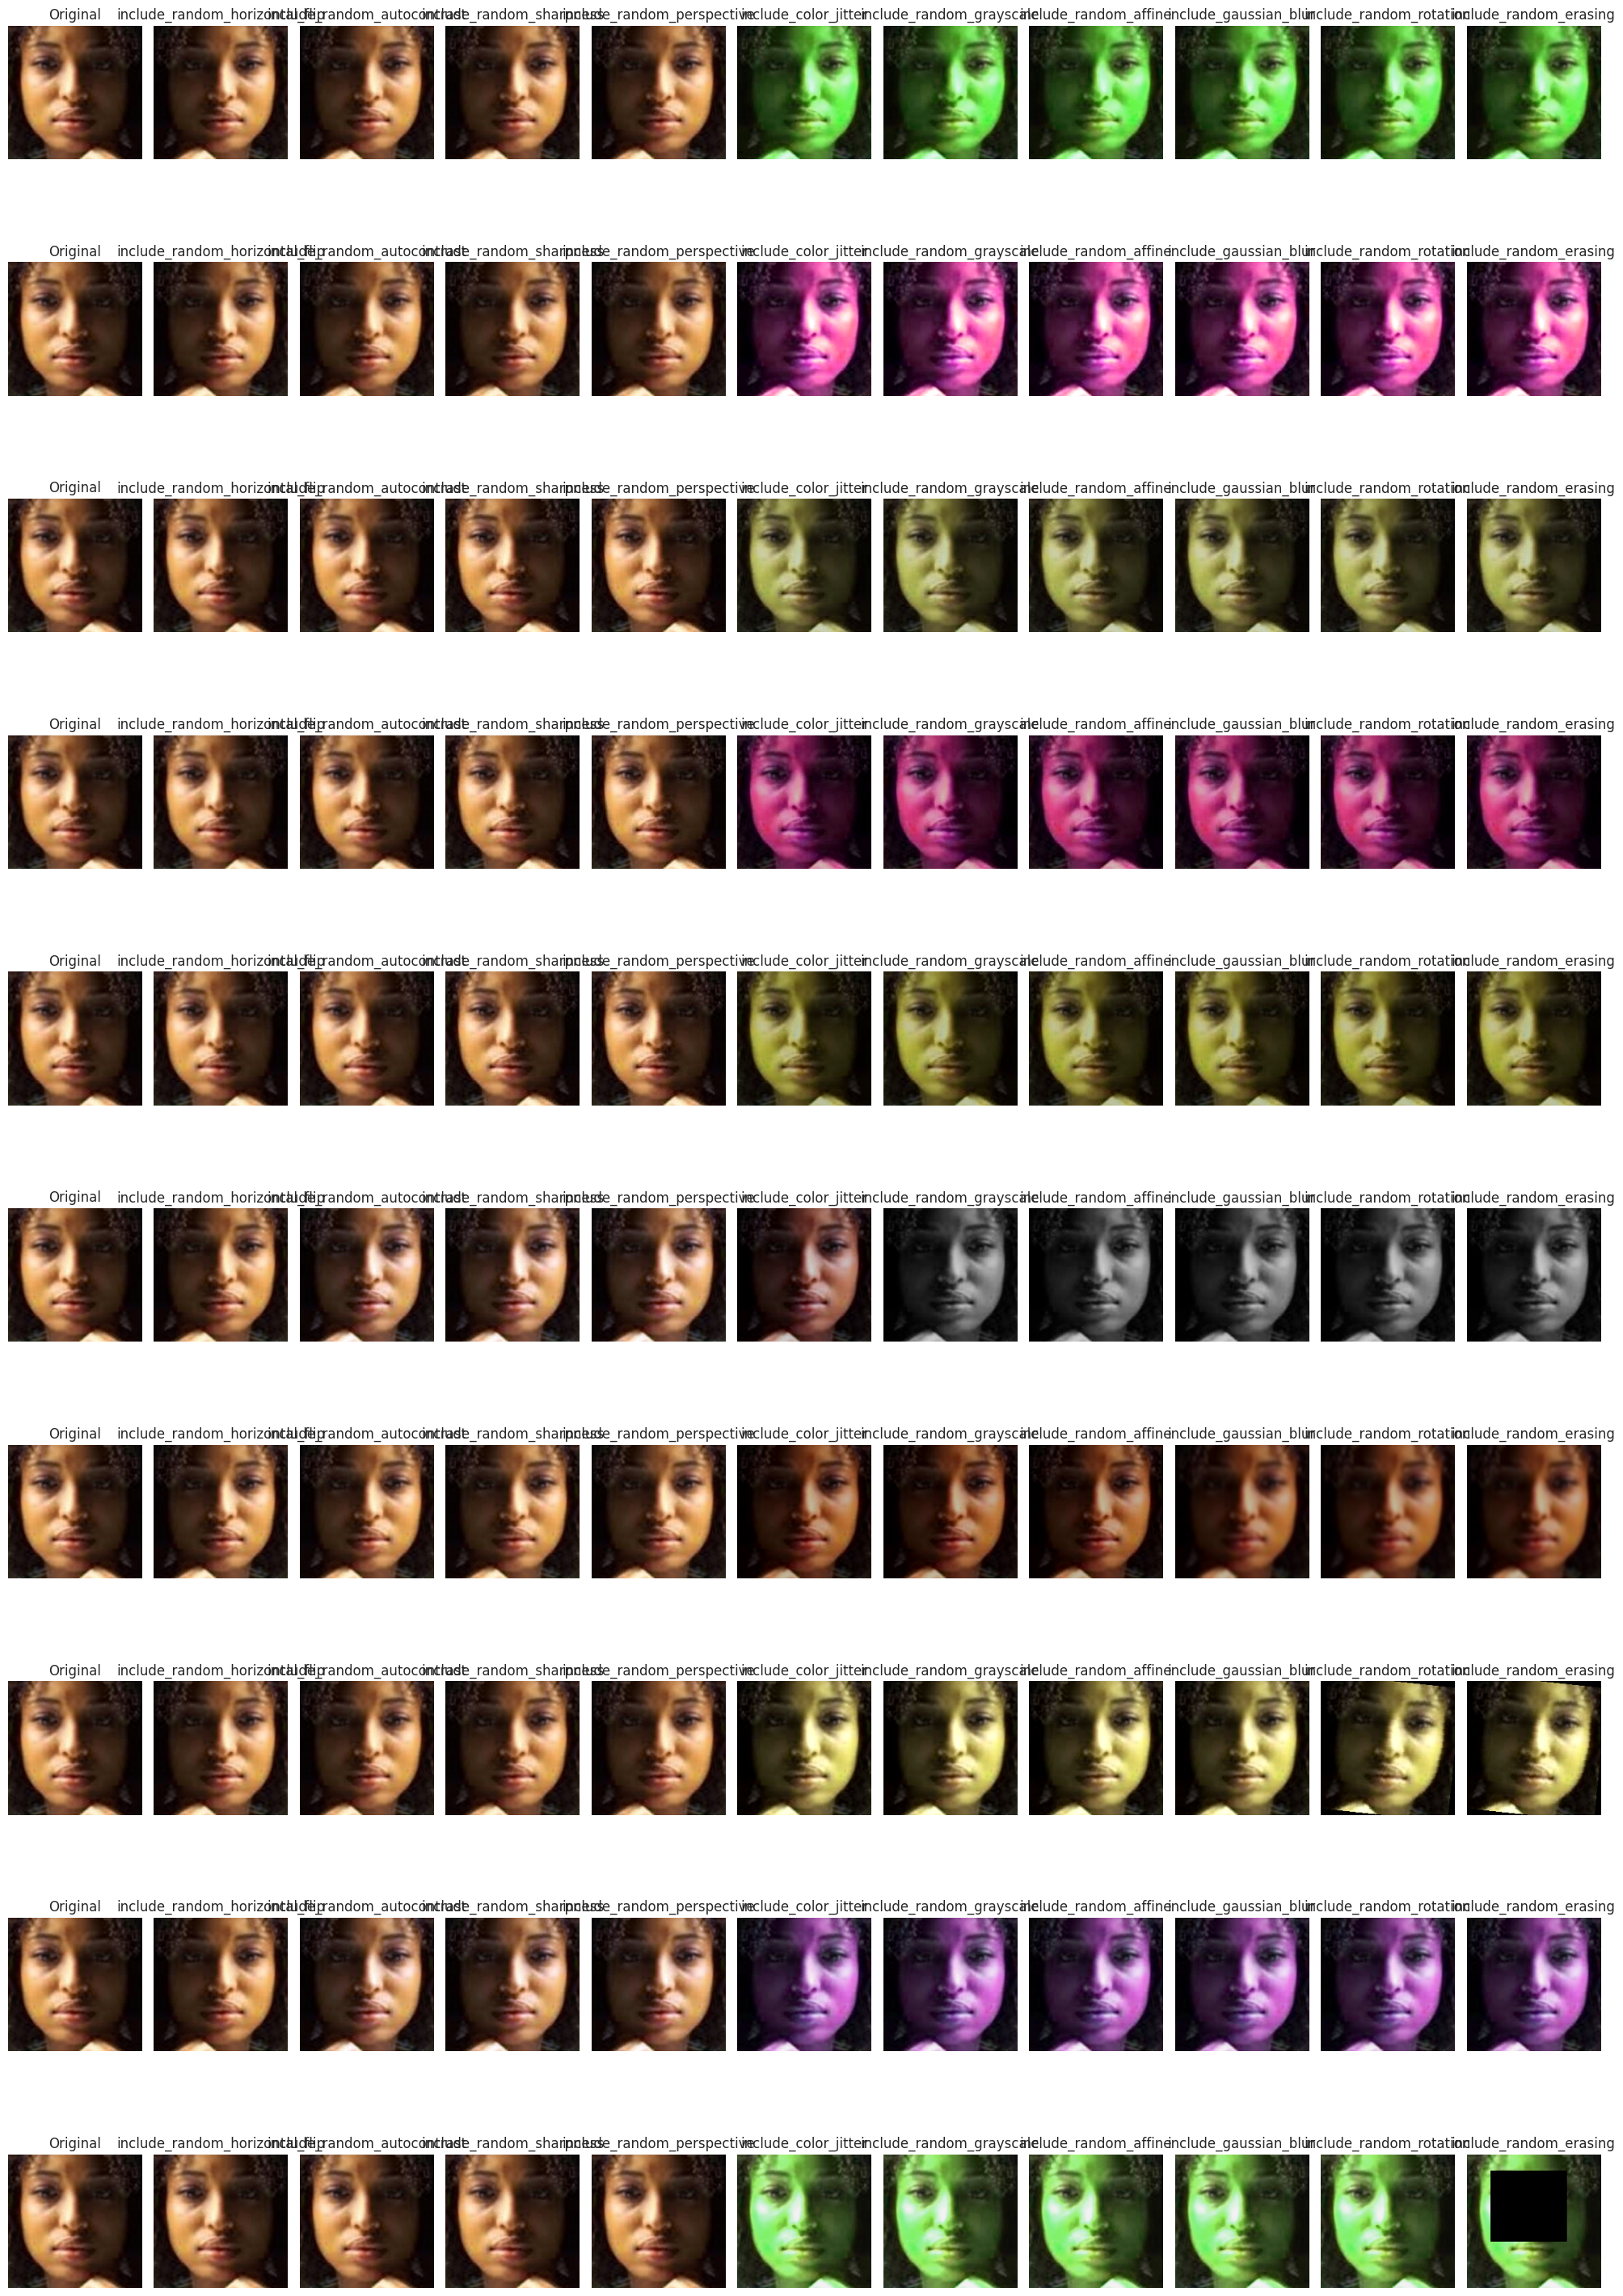

In [14]:
importlib.reload(data_defs)
visualize_transforms(
    "dataset/full/26_1_1_20170113193249379.jpg.chip.jpg",
    transforms_configs=data_defs.get_dynamic_augmentations(
        include_normalize=False, boost=True
    ),
    num_rows=10,
)
#### Selecting Best Transformers: